###  All Possible Regression

Python reimplementation of the Section 3.4. in PCDS.
Python data and some code from https://www.kaggle.com/divan0/multiple-linear-regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

#importing dataset using panda
dataset = pd.read_csv('../../data/kc_house_data.csv')
#to see what my dataset is comprised of
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [2]:
#dropping the id and date column
dataset = dataset.drop(['id','date'], axis = 1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

Simplest regression. How does square footage predict price by regression.  

In [3]:
from sklearn.linear_model import LinearRegression

X = np.array(dataset.sqft_living)
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],1))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.4928817196006995


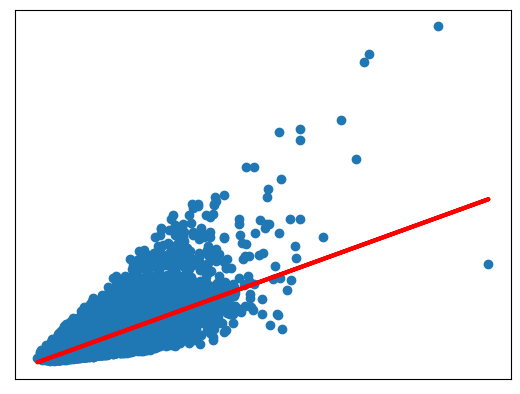

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# scatter data
plt.plot(X,Y,'o')
# best fit line
y_pred = model.intercept_ + model.coef_ * X
plt.plot(X, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Multiple Linear Regression

Adding more variables often improves the score.  The best possible regression score is 1.0.

In [5]:
X = np.array(dataset[['sqft_living','condition','yr_built']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5249639858277426


but some variables are confounding

In [6]:
X = np.array(dataset[['zipcode','floors','waterfront']])
Y = np.array(dataset.price)

# shape X into matrix of a single column
X = X.reshape((X.shape[0],3))

model = LinearRegression()
model.fit(X,Y)
r_sq = model.score(X,Y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.13588749977708758


This leads to a first parallel program.  What are the right set of variables. A brute force approach called _All Possible Regressions_. So, let's build a big matrix that and we will regress on subsets.

In [7]:
from itertools import combinations, chain

Y = np.array(dataset.price)
X = np.array(dataset.drop(['price'], axis=1))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(X.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

In [8]:
%%timeit

model = LinearRegression()

# do in a for loop (dumbest way)
r_sq_best = 0.0
for combo in combos:
    Xp = X[:,combo]
#    print(combo)
#    print(Xp.shape, Xp[0:10,:])
#    print(Xp.shape)
    model = model.fit(Xp,Y)
    r_sq = model.score(Xp,Y)
    if r_sq > r_sq_best:
        r_sq_best = r_sq
        combo_best = combo
    
print(r_sq_best, combo_best)

0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
2.41 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The outcome is kind of crazy. The fields are `sqft-living`, `view`, and `latitude`. Latitude is probably a somewhat accurate proxy for wealth in this area, e.g. N of town richer than south of town. But, this is the kind of outcome that does not translate to other areas.

Back to performance.

Let's see if a loop comprehension helps much.  Remove control variable overhead.

In [9]:
def r_sq_regression (combo):
    Xp = X[:,combo]
    model = LinearRegression()
    model = model.fit(Xp,Y)
    return model.score(Xp,Y)

In [10]:
%%timeit
               
r_sq_list = [ (combo, r_sq_regression(combo)) for combo in combos ]
r_sq_arr = np.array(r_sq_list, dtype=object)

r_sq_idx = np.argmax(r_sq_arr[:,1])
print(r_sq_arr[r_sq_idx])

[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
[(2, 6, 14) 0.6095149101819038]
2.18 s ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It didn't seem to help. Maybe worse because of function call overhead.

__RB talk about parallelization strategies here.  How to decompose.  Why?__

and we can try to parallelize internally. because sklearn has joblib for individual calls.  not very effective. no parallelism available

Now parallelize this let's do this with joblib

In [11]:
%%timeit
from joblib import Parallel, delayed
r_sq_arr = Parallel(n_jobs=4)(delayed(r_sq_regression)(combo) for combo in combos)

r_sq_idx = np.argmax(r_sq_arr)
print(r_sq_arr[r_sq_idx], combos[r_sq_idx])

0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
0.6095149101819038 (2, 6, 14)
599 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Activities -- explore the parameters of joblib.
  * number of cores
  * thread versus process scheduler
  * batch size  (very suprising that the batch size documentation says that 1 is reasonable)
  * pre-dispatch -- this is dynamic scheduling
  
  
Things in Chapter that we didn't talk about.  Choice of parallelization strategies.

At only 987 jobs, what batch size will provde the right amount of parallelism.
Trades startup costs, versus skew.  What batch size was chosen by the default?  Why is that a reasonable choice?

This should come in a section about startup versus skew/load balance

In [12]:
from joblib import Parallel, delayed

# check out batch sizes
%timeit Parallel(n_jobs=4, batch_size=1)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=2)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=4)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=8)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=16)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=32)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=64)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=128)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=256)(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, batch_size=512)(delayed(r_sq_regression)(combo) for combo in combos)

921 ms ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
771 ms ± 8.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
676 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
616 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
610 ms ± 60.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
574 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
565 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
573 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
575 ms ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
576 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Explore process v. thread scheduler

This result is very surprising. Threads should be better, but they aren't.  Some part of our code is not releasing the GIL.  Put in a section on the python GIL.

In [13]:
from joblib import Parallel, delayed

# check out batch sizes
%timeit Parallel(n_jobs=4, prefer='threads')(delayed(r_sq_regression)(combo) for combo in combos)
%timeit Parallel(n_jobs=4, prefer='processes')(delayed(r_sq_regression)(combo) for combo in combos)

3.34 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
580 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try making the call only to the scikit-learn and see if our function is the problem with the GIL.   This ends up very interesting.  It makes threading faster, because the GIL is less of a problem, but it's a problem to serialize/marshall the model objects across the processes.  So, no easy fix for this code.  **Careful** the processes call will crash your Jupyter. 

In [14]:
from joblib import Parallel, delayed

%timeit Parallel(n_jobs=4, prefer='threads')(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combos)
#%timeit Parallel(n_jobs=4, prefer='processes')(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combos)



3.01 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Explore dispatch, dynamic schedule

In [15]:
from joblib import Parallel, delayed

%timeit Parallel(n_jobs=4, pre_dispatch=4)(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combos)
%timeit Parallel(n_jobs=4, pre_dispatch=64)(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combos)
%timeit Parallel(n_jobs=4, pre_dispatch='all')(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combos)
#%timeit Parallel(n_jobs=4, prefer='processes')(delayed(LinearRegression().fit)(X[:,combo],Y) for combo in combo

793 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
728 ms ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
721 ms ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**RBTODO** work on decomposition issues with dask.

### Reusing Work with 

$$\beta = (X'X)^{-1}X'Y$$

this example is driven from https://online.stat.psu.edu/stat462/node/132/

making sure that we have the linear algebra right.  The standard is to add a constant term to the predictor matrix, that is the column of ones.

In [16]:
import numpy as np

X1 = np.ones([7,1])
X2 = np.array([[4.0], [4.5], [5.0], [5.5], [6.0], [6.5], [7.0]])

Y = np.array([[33], [42], [45], [51], [53], [61], [62]])

X = np.append(X1,X2,axis=1)
XtX = (X.transpose().dot(X))

XtXi = np.linalg.inv(XtX)

print(XtXi)

XtY = X.transpose().dot(Y)

#print(XtY)

beta = XtXi.dot(XtY)

print(beta)

[[ 4.46428571 -0.78571429]
 [-0.78571429  0.14285714]]
[[-2.67857143]
 [ 9.5       ]]


Validate against python. OK interesing it's not exactly the same, but it becomes the same when we use `fit_intercept`

In [17]:
model = LinearRegression(fit_intercept=False)
model.fit(X,Y)
model.coef_

array([[-2.67857143,  9.5       ]])

now, onto the big matrix.  Still adding a column of ones.

In [18]:
#importing dataset using panda
dataset = pd.read_csv('../../input/kc_house_data.csv')

#dropping the id and date column
dataset = dataset.drop(['id','date'], axis = 1)

# clean out NaN and inf values
dataset = dataset[~dataset.isin([np.nan, np.inf, -np.inf]).any(1)]

Y = np.array(dataset.price)

Xcols= np.array(dataset.drop(['price'], axis=1))
print(Xcols.shape)
X1 = np.ones((Xcols.shape[0],1))
#print(X1.shape)
X = np.append(X1,Xcols,axis=1)
#print(X.shape)
#print(X)

XtX = (X.transpose().dot(X))
XtXi = np.linalg.inv(XtX)

#print(XtXi.shape)

XtY = X.transpose().dot(Y)

#print(XtY.shape)

beta = XtXi.dot(XtY)
beta

FileNotFoundError: [Errno 2] No such file or directory: '../../input/kc_house_data.csv'

Compare our beta with the model

In [ ]:
model = LinearRegression(fit_intercept=False)
model.fit(X,Y)
model.coef_

OK get it right for 1 column on the big data.

In [ ]:
Xcols= np.array(dataset.drop(['price'], axis=1))
Xcols=Xcols[:,3].reshape([-1,1])
X1 = np.ones((Xcols.shape[0],1))
#print(X1.shape)
#print(Xcols.shape)
X = np.append(X1,Xcols,axis=1)

model = LinearRegression(fit_intercept=False)
model.fit(X,Y)
print(model.coef_)

XtX = (X.transpose().dot(X))
XtXi = np.linalg.inv(XtX)
#print(XtXi)
XtY = X.transpose().dot(Y)
beta = XtXi.dot(XtY)
print(beta)

Let's try for two.

In [ ]:
Xcols= np.array(dataset.drop(['price'], axis=1))
Xcols=Xcols[:,3:5]
X1 = np.ones((Xcols.shape[0],1))
#print(X1.shape)
#print(Xcols.shape)
X = np.append(X1,Xcols,axis=1)

model = LinearRegression(fit_intercept=False)
model.fit(X,Y)
print(model.coef_)

XtX = (X.transpose().dot(X))
#print(XtX)
XtXi = np.linalg.inv(XtX)
#print(XtXi)
XtY = X.transpose().dot(Y)
beta = XtXi.dot(XtY)
print(beta)

ok, now let's subset from the full matrix and invert to solve

In [ ]:
#take the full matrix and compute XtX
Xall = np.array(dataset.drop(['price'], axis=1))
X1 = np.ones((Xcols.shape[0],1))
X = np.append(X1,Xall[:,:],axis=1)

#compute XtX on whole matrix
XtX = (X.transpose().dot(X))

#subset the relevant parameters
XtXsub = XtX[np.ix_([0,4,5],[0,4,5])]

#verify the same matrix subset
#print(XtXsub)

#compute based on subset
XtXi = np.linalg.inv(XtXsub)
XtY = X[:,[0,4,5]].transpose().dot(Y)
beta = XtXi.dot(XtY)
print(beta)

We have verified the correctness of the subset. Let's run the experiment using shared, pre-computed XtX.  First do it in a for loop.

In [ ]:
from itertools import combinations, chain

#take the full matrix and compute XtX
Xall = np.array(dataset.drop(['price'], axis=1))
X1 = np.ones((Xcols.shape[0],1))
X = np.append(X1,Xall[:,:],axis=1)

#compute XtX on whole matrix
XtX = (X.transpose().dot(X))

## Let's choose all combinations of 1, 2, and 3 columns.
col_idxs = np.array(range(Xall.shape[1]))
combos = list(chain(combinations(col_idxs, 1), combinations(col_idxs, 2), combinations(col_idxs, 3)))

# indexing is off by one 3,4 -> 4,5 because we added X1
for combo in combos:
    thiscombo = [0] + [x+1 for x in combo]
    #print(thiscombo)
    XtXsub = XtX[np.ix_(thiscombo,thiscombo)]
    #print(XtXsub)
    XtXi = np.linalg.inv(XtXsub)
    XtY = X[:,thiscombo].transpose().dot(Y)
    beta = XtXi.dot(XtY)
    #print(beta)

In [ ]:
def work_shared_regression (combo):
    thiscombo = [0] + [x+1 for x in combo]
    XtXsub = XtX[np.ix_(thiscombo,thiscombo)]
    XtXi = np.linalg.inv(XtXsub)
    XtY = X[:,thiscombo].transpose().dot(Y)
    beta = XtXi.dot(XtY)
    return beta

In [ ]:
%%timeit
from joblib import Parallel, delayed

# you must pay for the global setup

#compute XtX on whole matrix
XtX = (X.transpose().dot(X))

#then parallelize with work sharing
betas = Parallel(n_jobs=4)(delayed(work_shared_regression)(combo) for combo in combos)
#print(betas)